# Bulk Enrichment Analysis

Bulk RNA-seq yields many molecular readouts that are hard to interpret by themselves.
One common approach to summarize this data is to compute enrichment scores using
predefined gene sets based on prior biological knowledge.

This notebook demonstrates the use of `decoupler` to infer transcription factor (TF)
and pathway enrichment scores from a bulk RNA-seq dataset of a human cell line {cite:p}`hsc_tgfb`.

The dataset includes six samples of hepatic stellate cells (HSCs), three of which
were activated with the cytokine Transforming Growth Factor beta (TGF-β).
It is publicly available at
GEO ([GSE151251](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE151251)).


## Loading Packages

In [1]:
import numpy as np
import scanpy as sc
import decoupler as dc

sc.set_figure_params(figsize=(3, 3), frameon=False)

## Loading The Dataset

In [2]:
adata = dc.ds.hsctgfb()
adata

AnnData object with n_obs × n_vars = 6 × 58674
    obs: 'condition', 'sample_id'

The obtained {class}`anndata.AnnData` consist of raw integer transcript counts for six different samples
(three controls, three treatments) with measurements for ~60k genes.

We can inspect the sample metadata stored in {attr}`anndata.AnnData.obs`.

In [3]:
adata.obs

,condition,sample_id
25_HSCs-Ctrl1,control,25
26_HSCs-Ctrl2,control,26
27_HSCs-Ctrl3,control,27
31_HSCs-TGFb1,treatment,31
32_HSCs-TGFb2,treatment,32
33_HSCs-TGFb3,treatment,33


And visualized.

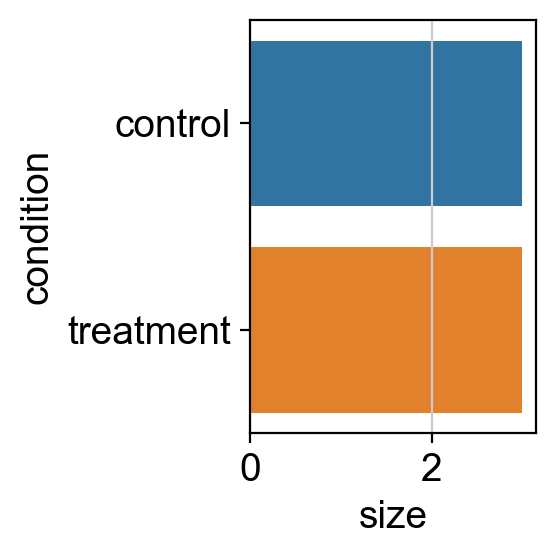

In [4]:
dc.pl.obsbar(
    adata=adata,
    y='condition',
    hue='condition',
    figsize=(3, 3)
)

Although this plot is simple in the current example,
it can be useful in more complex experimental designs.

## Preprocessing
### Quality Control

Before proceeding, we need to ensure that our data meets basic quality control standards.
In transcriptomics, some genes may be poorly profiled and should be excluded from analysis.

To filter genes, we follow the approach used in the `filterByExpr` function from
[`edgeR`](https://rdrr.io/bioc/edgeR/man/filterByExpr.html) {cite:p}`edger`.
This method retains genes that meet two criteria:

1) A minimum total read count across all samples (`min_total_count`)
2) A minimum read count in a minimum number of samples (`min_count`)

We can visualize how many genes are retained under different filtering thresholds.

Feel free to adjust the parameters of `decoupler.pl.filter_by_expr` to explore
how they affect gene retention.

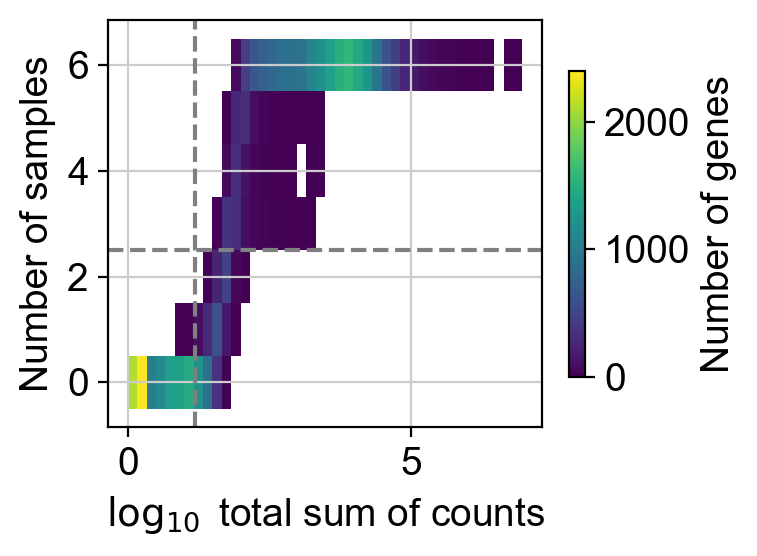

In [5]:
dc.pl.filter_by_expr(
    adata=adata,
    group='condition',
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.7,
)

Here, we visualize the distribution of genes by their total count across all samples and the number of
samples in which they are expressed. The dashed lines represent the current filtering thresholds, only
genes in the upper-right corner will be retained.

While filtering thresholds are somewhat arbitrary, a common strategy is to look for bimodal distributions
and set thresholds that separate low-expression (potentially noisy) genes from those with more
robust expression.

In this example, the default settings strike a balance by retaining a substantial number of genes while
filtering out likely noise.

<div class="alert alert-info">
    
**Note**

Changing the value of `min_count` will significantly affect the distribution of the "Number of samples"
but will not directly change its threshold. To adjust this threshold, either to lower or raise it, 
you'll need to modify the `group`, `large_n`, and `min_prop` parameters.

</div>

<div class="alert alert-info">

**Note**

Filtering thresholds can vary greatly between datasets, so manual assessment is important.

</div>

Once you're satisfied with the threshold parameters, you can proceed with the actual filtering
with the function `decoupler.pp.filter_by_expr`.

In [6]:
dc.pp.filter_by_expr(
    adata=adata,
    group='condition',
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.7,
)

### Variability Exploration
Before performing any test between groups,
it is a good practice to explore the variability
of the omics profiles.

This involves some basic preprocessing followed by principal component analysis (PCA).

In [7]:
# Store raw counts in layers
adata.layers['counts'] = adata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)

# Return raw counts to X
dc.pp.swap_layer(
    adata=adata,
    key='counts',
    inplace=True
)

After computing the PCs, associations or correlations between each inferred PC and the variables
in the metadata can be tested, depending on whether the variables are categorical or continuous.

This type of analysis is applicable to any dimensionality reduction method, such as factors
derived from non-negative matrix factorization.

In [8]:
dc.tl.rankby_obsm(adata, key='X_pca')

The importance of each principal component (based on its explained variance ratio) and its associations
with metadata variables can then be visualized.

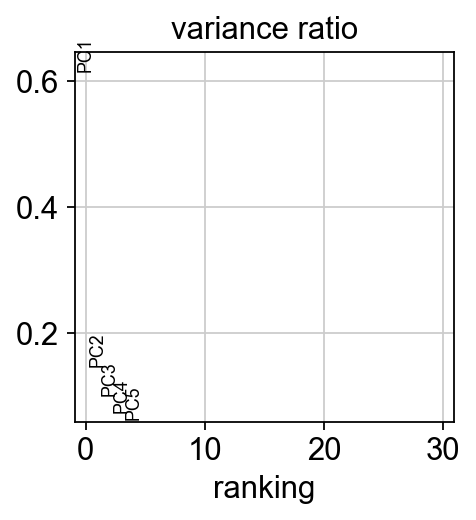

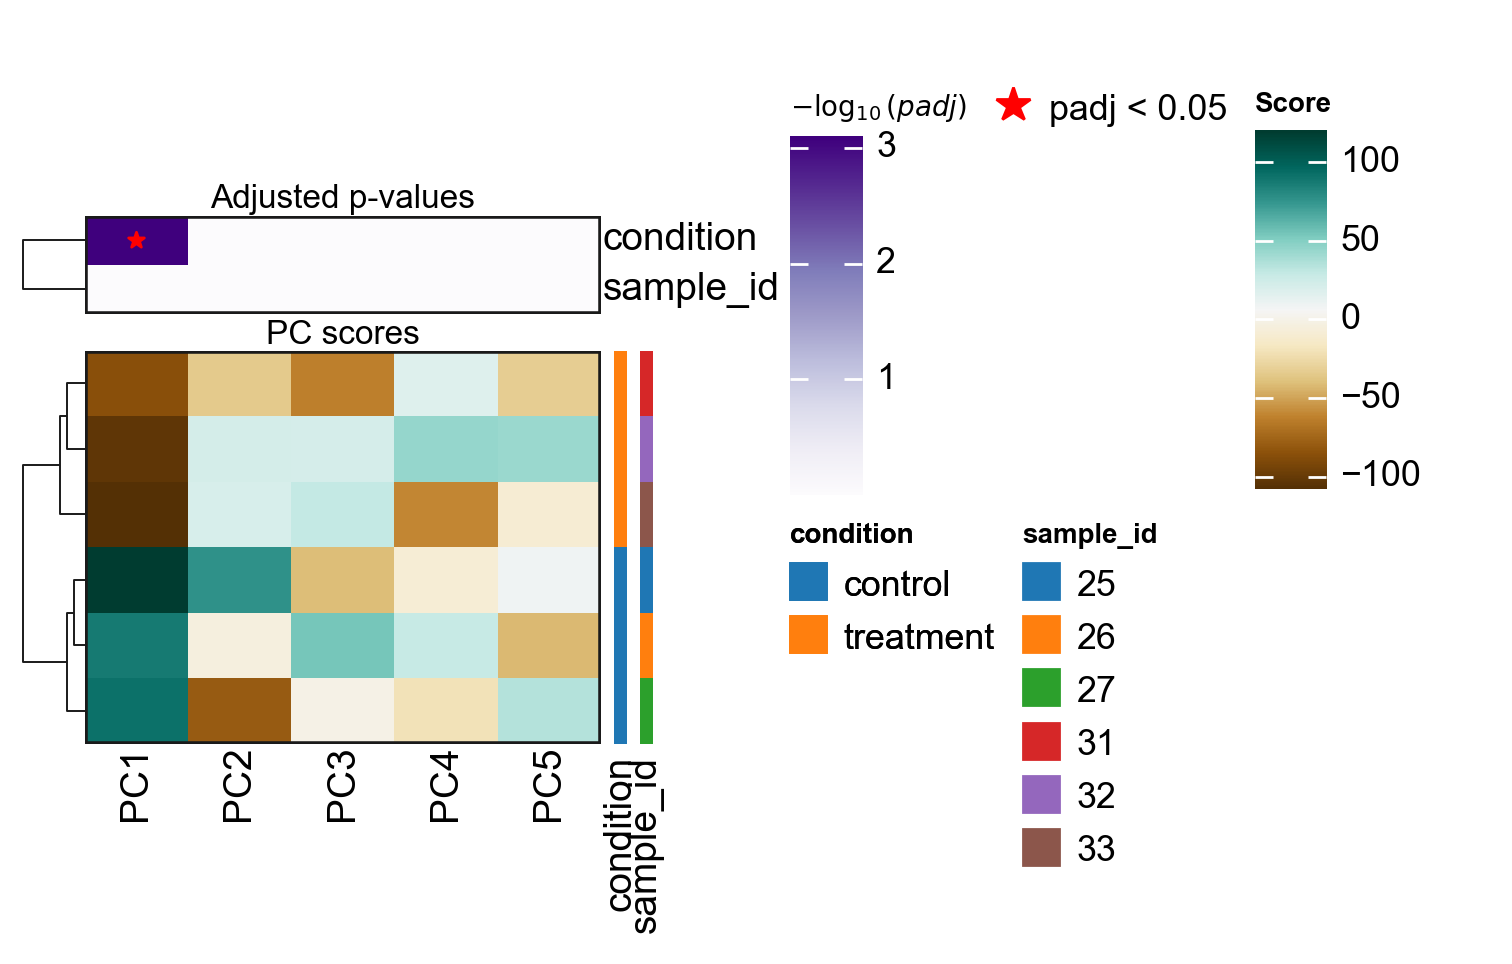

In [9]:
sc.pl.pca_variance_ratio(adata)
dc.pl.obsm(
    adata=adata,
    return_fig=True,
    nvar=5,
    titles=['PC scores', 'Adjusted p-values'],
    figsize=(6, 3)
)

In this dataset, PC1 appears to explain the largest proportion of variance and is associated
with the metadata variable "condition", which is a good indication that the experiment
worked.

Metadata variables associated with PCs that capture a substantial amount of variance are
important and should be accounted for as relevant covariates in downstream differential
expression analysis when possible.

The principal components can also be directly visualized, colored by these metadata variables.

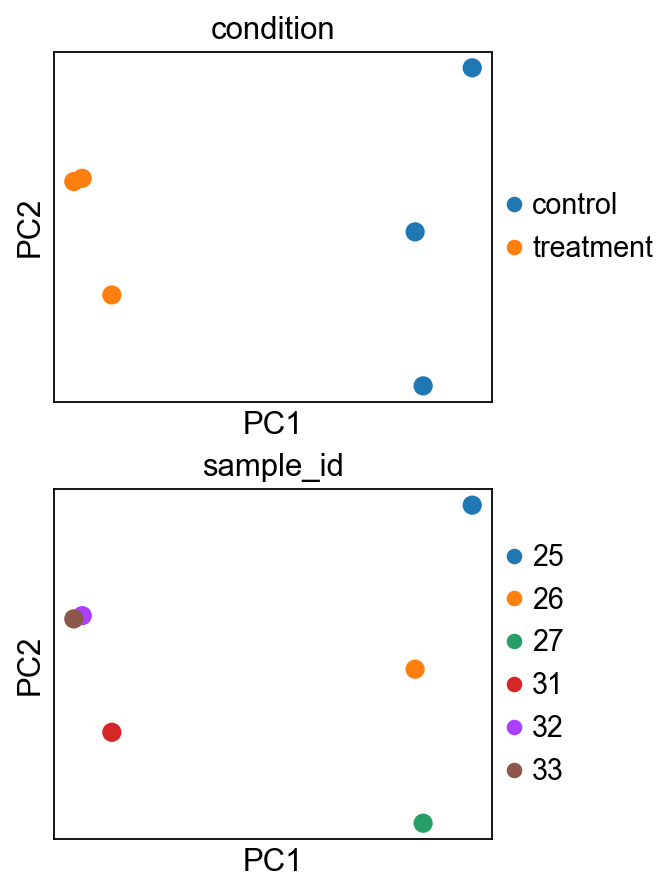

In [10]:
sc.pl.pca(
    adata,
    color=['condition', 'sample_id'],
    ncols=1,
    size=300,
    frameon=True,
)

### Differential Expression Analysis

To identify the genes that change most between treatment and control, we perform differential expression analysis (DEA).
In this example, we use a simple experimental design that compares gene expression in treated cells versus controls.

We will use the Python implementation of the `DESeq2` framework {cite:p}`pydeseq`, though other tools like `limma`
{cite:p}`limma` or `edgeR` {cite:p}`edger` could also be used.
For a deeper understanding of how `pyDESeq2` works, refer to its
[official documentation](https://pydeseq2.readthedocs.io/en/latest/).

Note that more complex experimental designs can be accommodated by adding additional factors to the `design_factors` argument.

In [11]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=adata,
    design_factors='condition',
    refit_cooks=True,
    inference=inference,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between conditions
stat_res = DeseqStats(
    dds,
    contrast=["condition", 'treatment', 'control'],
    inference=inference
)

# Compute Wald test
stat_res.summary()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 6.30 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 6.19 seconds.

Fitting LFCs...
... done in 3.50 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.59 seconds.



Log2 fold change & Wald test p-value: condition treatment vs control
                  baseMean  log2FoldChange     lfcSE       stat  \
RP11-347I19.8    88.877997       -0.207128  0.252585  -0.820033   
TMEM170B        103.807801       -0.276961  0.210597  -1.315124   
RP11-91P24.6    185.514929       -0.305849  0.180945  -1.690287   
SLC33A1        2559.269047        0.595912  0.085219   6.992732   
SNORA61          66.168502        0.746768  0.266506   2.802073   
...                    ...             ...       ...        ...   
RP11-75I2.3     771.828248        3.812419  0.128093  29.762958   
SLC25A24       3525.523888        0.651017  0.087564   7.434777   
BTN2A2          674.018191       -0.107905  0.106204  -1.016023   
RP11-101E3.5    194.084339        0.092515  0.181979   0.508385   
RP11-91I8.3      10.761886       -3.804540  0.920285  -4.134090   

                      pvalue           padj  
RP11-347I19.8   4.121975e-01   5.540839e-01  
TMEM170B        1.884683e-01   3.0

In [12]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
RP11-347I19.8,88.877997,-0.207128,0.252585,-0.820033,4.121975e-01,5.540839e-01
TMEM170B,103.807801,-0.276961,0.210597,-1.315124,1.884683e-01,3.054254e-01
RP11-91P24.6,185.514929,-0.305849,0.180945,-1.690287,9.097300e-02,1.682673e-01
SLC33A1,2559.269047,0.595912,0.085219,6.992732,2.695835e-12,2.377746e-11
SNORA61,66.168502,0.746768,0.266506,2.802073,5.077534e-03,1.383944e-02
...,...,...,...,...,...,...
RP11-75I2.3,771.828248,3.812419,0.128093,29.762958,1.178788e-194,3.833025e-192
SLC25A24,3525.523888,0.651017,0.087564,7.434777,1.047442e-13,1.026915e-12
BTN2A2,674.018191,-0.107905,0.106204,-1.016023,3.096184e-01,4.489859e-01
RP11-101E3.5,194.084339,0.092515,0.181979,0.508385,6.111834e-01,7.290599e-01


The results can be visualized using a volcano plot.

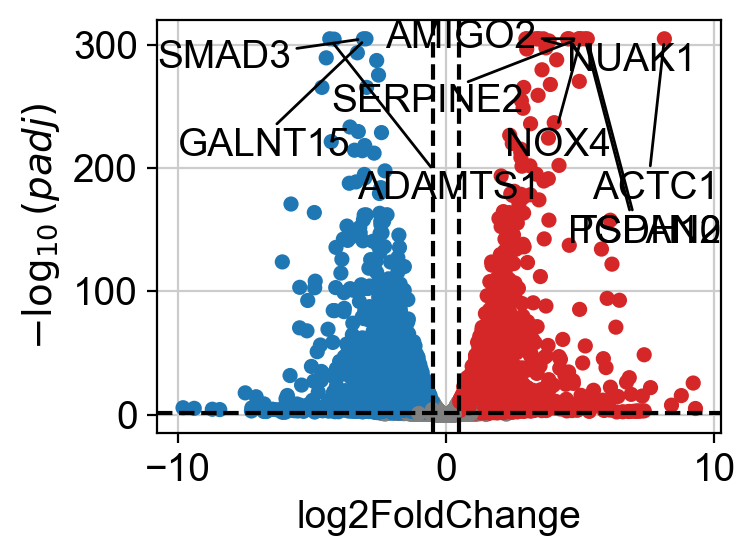

In [13]:
dc.pl.volcano(
    data=results_df,
    x='log2FoldChange',
    y='padj',
    top=10,
)

After performing DEA, we can use the resulting gene-level statistics for enrichment analysis.
While any statistic can be used, we recommend using t-values rather than `log2FCs`,
as t-values account for the significance of the change.
We will transform the obtained t-values, stored in the column `stat`, into a wide matrix
format so that it can be used with `decoupler`.

In [14]:
data = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
data

,RP11-347I19.8,TMEM170B,RP11-91P24.6,SLC33A1,SNORA61,THAP9-AS1,LIX1L,TTC8,WBSCR22,LPHN2,...,STARD4-AS1,ZNF845,NIPSNAP3B,ARL6IP5,MATN1-AS1,RP11-75I2.3,SLC25A24,BTN2A2,RP11-101E3.5,RP11-91I8.3
treatment.vs.control,-0.820033,-1.315124,-1.690287,6.992732,2.802073,1.531631,2.164968,-0.579993,-0.945967,-14.354905,...,14.489549,0.567183,-1.882506,-8.428726,-1.739315,29.762958,7.434777,-1.016023,0.508385,-4.13409


## Enrichment analysis

Enrichment analysis tests whether a specific set of omics features is "overrepresented"
or "coordinated" in the measured data compared to a background distribution.
These sets are predefined based on existing biological knowledge and may vary depending
on the omics technology used.

Enrichment analysis requires the use of an enrichment method, and several options are
available.
In the original manuscript of `decoupler` {cite:p}`decoupler`, we benchmarked multiple
methods and found that the univariate linear model (`ulm`) outperformed the others.
Therefore, we will use `ulm` in this vignette. 

The scores from `decoupler.mt.ulm` should be interpreted such that larger magnitudes
indicate greater significance, while the sign reflects whether the features in the set are
overrepresented (positive) or underrepresented (negative) compared to the background.

### Transcription factor scoring from gene regulatory networks

Transcription factors (TFs) are genes that, once translated into proteins, bind to DNA
and regulate the expression of other genes by either promoting or inhibiting their
transcription. Gene Regulatory Networks (GRNs) capture these TF-gene interactions and
can be constructed from prior knowledge or inferred from omics data. The fundamental
unit of a GRN is a TF and its associated target genes, collectively known as a *regulon*.
Each regulon functions as a gene set in enrichment analysis.

Although TFs are measured in transcriptomic data, their transcript levels often do not
reflect their actual activity in a given cell. Instead, scoring TFs through enrichment
analysis based on the expression of their target genes provides a more accurate
representation of their regulatory activity {cite:p}`grn_review`.

#### CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource containing a curated
collection of TFs and their transcriptional targets compiled from 12 different resources {cite:p}`collectri`. This collection
provides an increased coverage of transcription factors and a superior performance in identifying perturbed
TFs compared to other literature based GRNs such as 
[DoRothEA](https://saezlab.github.io/dorothea/) {cite:p}`dorothea`.
Similar to DoRothEA, interactions are weighted by their mode of regulation
(activation or inhibition).

In this tutorial we will use the human version but other organisms are available.
We can use `decoupler` to retrieve it from the [OmniPath](https://omnipathdb.org/) server.

<div class="alert alert-info">

**Note**

In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 
</div> 

In [15]:
collectri = dc.op.collectri(organism='human')
collectri

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
...,...,...,...,...,...,...
42985,NFKB,hsa-miR-143-3p,1.0,ExTRI,19472311,default activation
42986,AP1,hsa-miR-206,1.0,ExTRI;GEREDB;NTNU.Curated,19721712,PMID
42987,NFKB,hsa-miR-21,1.0,ExTRI,20813833;22387281,default activation
42988,NFKB,hsa-miR-224-5p,1.0,ExTRI,23474441;23988648,default activation


#### Scoring
We can easily compute TF scores by running the `ulm` method.

In [16]:
# Run
tf_acts, tf_padj = dc.mt.ulm(data=data, net=collectri)

# Filter by sign padj
msk = (tf_padj.T < 0.05).iloc[:, 0]
tf_acts = tf_acts.loc[:, msk]

tf_acts

,APEX1,ARID1A,ARID4B,ARNT,ASXL1,ATF6,BARX2,BCL11A,BCL11B,BMAL2,...,TBX10,TCF21,TFAP2C,TP53,VEZF1,WWTR1,ZBTB33,ZEB2,ZNF804A,ZXDC
treatment.vs.control,-2.65798,-3.916049,-2.80643,3.17109,3.74431,2.705803,5.355843,2.647933,-4.201797,3.866924,...,-3.702477,6.159993,-2.578059,-3.570739,4.206326,-3.966869,3.235394,5.787616,3.362941,-2.732602


The obtained scores for the most active and inactive TFs can be visualized as follows.

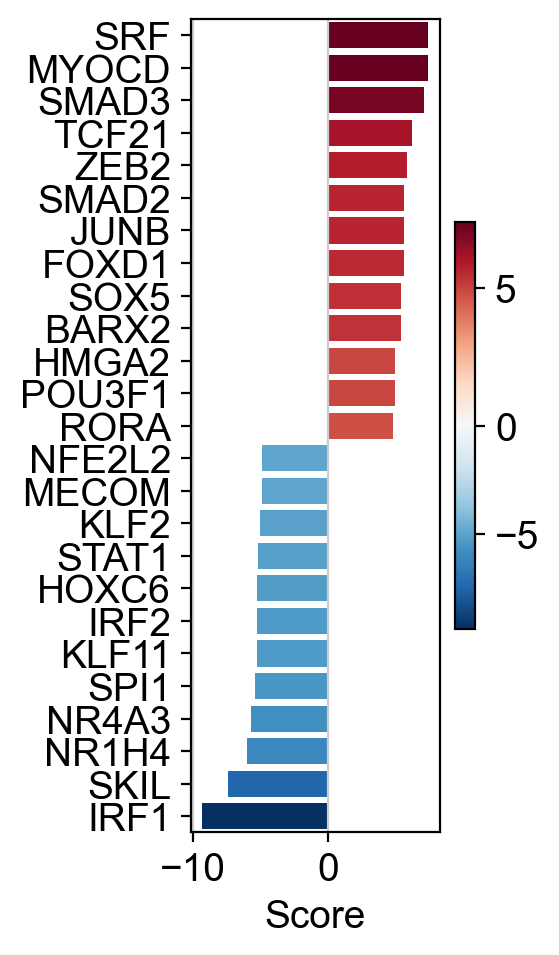

In [17]:
dc.pl.barplot(
    data=tf_acts,
    name='treatment.vs.control',
    top=25,
    figsize=(3, 5)
)

SRF, MYOCD and SMAD3 appear to be the most activated TFs in this treatment,
while IRF1, SKIL and NR1H4 appear to be inactivated.

A network of selected TFs (top and bottom ranked by activity) can also be visualized, with nodes colored by TF activity and
target gene expression.

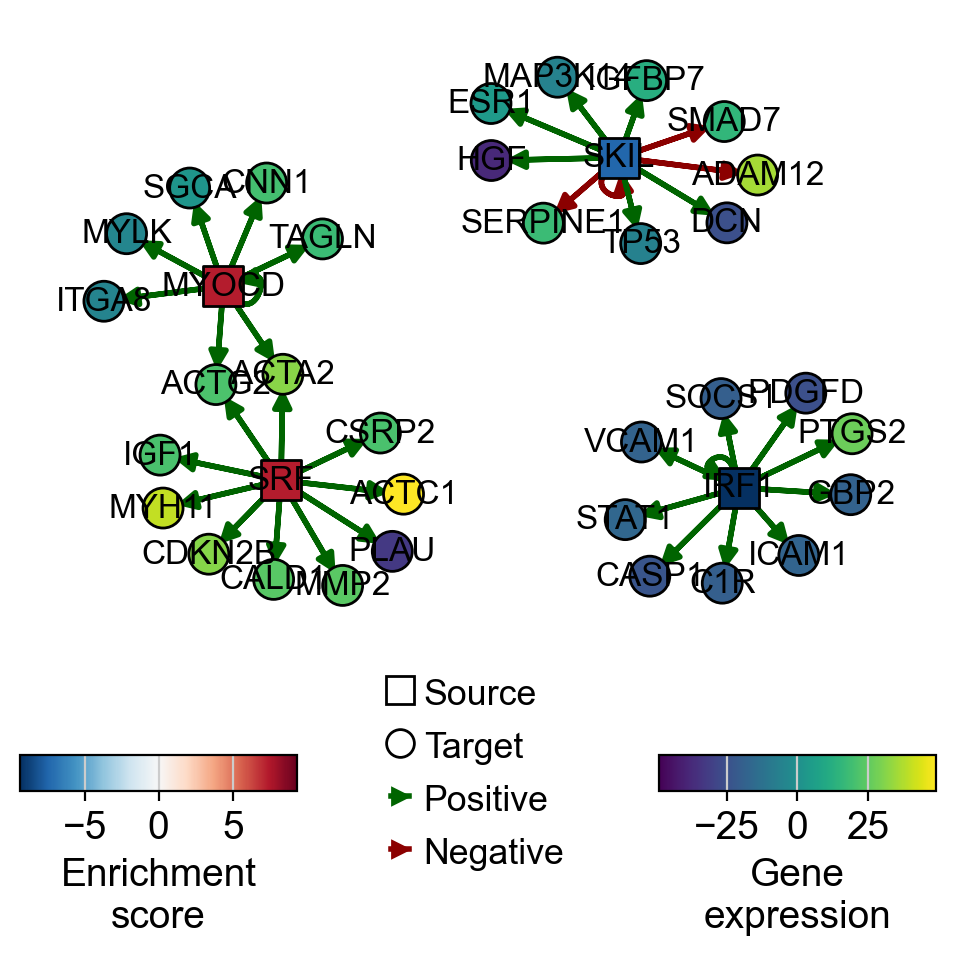

In [18]:
dc.pl.network(
    net=collectri,
    data=data,
    score=tf_acts,
    sources=['SRF', 'MYOCD', 'IRF1', 'SKIL'],
    targets=10,
    figsize=(5, 5),
    vcenter=True,
    by_abs=True,
    size_node=10
)

SRF appears to be active in treated cells, as its positively regulated targets are upregulated.

If needed, we can also look at a volcano plot of the target genes.

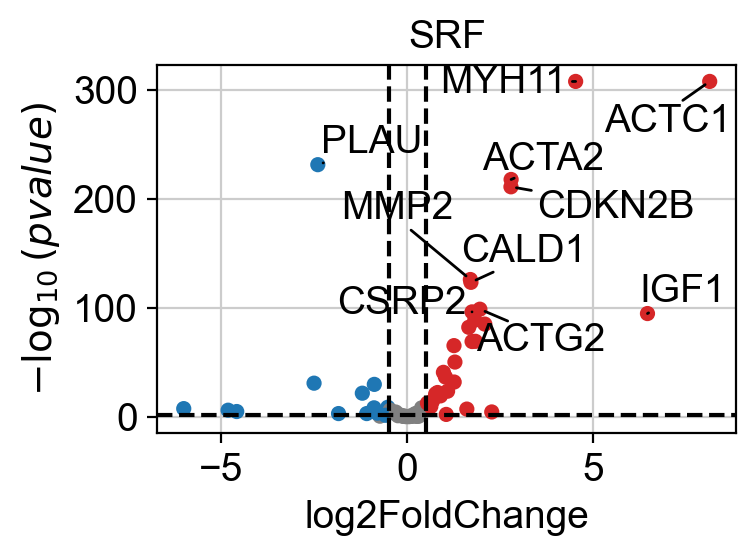

In [19]:
dc.pl.volcano(
    data=results_df,
    x='log2FoldChange',
    y='pvalue',
    net=collectri,
    name='SRF',
    top=10,
)

### Pathway Scoring

The same approach used for TF scoring can also be applied to pathways. Numerous
databases provide curated pathway gene sets, with one of the most well-known being MSigDB, which
includes several collections {cite:p}`msigdb`. 
These and many other resources can be accessed using the function {func}`decoupler.op.resource`.
To view the list of available databases, use {func}`decoupler.op.show_resources`.

#### PROGENy Pathway Genes
[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource that provides a curated
collection of pathways and their target genes, along with weights for each interaction
{cite:p}`progeny`.

Below is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation
- **MAPK**: integrates external signals and promotes cell growth and proliferation
- **NFkB**: regulates immune response, cytokine production and cell survival
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression
- **PI3K**: promotes growth and proliferation
- **TGFb**: involved in development, homeostasis, and repair of most tissues
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection
- **Trail**: induces apoptosis
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration
- **WNT**: regulates organ morphogenesis during development and tissue repair

This is how to access to it.

In [20]:
progeny = dc.op.progeny(organism='human')
progeny

,source,target,weight,padj
0,Androgen,TMPRSS2,11.490631,2.384806e-47
1,Androgen,NKX3-1,10.622551,2.205102e-44
2,Androgen,MBOAT2,10.472733,4.632376e-44
3,Androgen,KLK2,10.176186,1.944410e-40
4,Androgen,SARG,11.386852,2.790210e-40
...,...,...,...,...
62456,p53,ENPP2,2.771405,4.993215e-02
62457,p53,ARRDC4,3.494328,4.996747e-02
62458,p53,MYO1B,-1.148057,4.997905e-02
62459,p53,CTSC,-1.784693,4.998864e-02


#### Scoring
We can easily compute pathway scores by running the `ulm` method.

In [21]:
# Run
pw_acts, pw_padj = dc.mt.ulm(data=data, net=progeny)

# Filter by sign padj
msk = (pw_padj.T < 0.05).iloc[:, 0]
pw_acts = pw_acts.loc[:, msk]

pw_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,VEGF,p53
treatment.vs.control,4.767318,17.24881,10.995306,5.69203,-14.29565,25.596424,-10.146465,24.612571,59.351703,-9.079214,11.461921,-12.578889


The obtained scores for the most active and inactive pathways can be visualized as follows

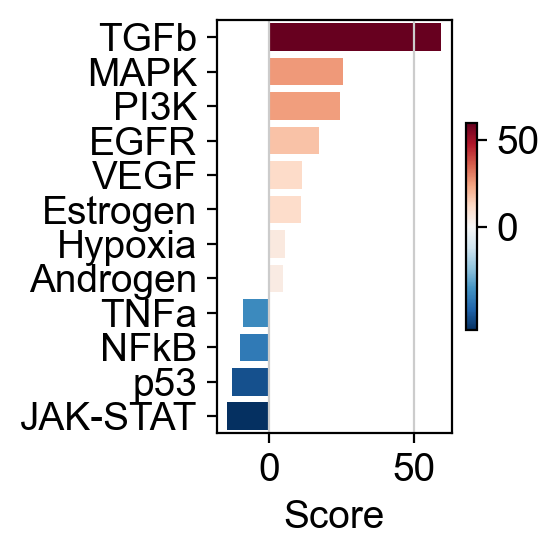

In [22]:
dc.pl.barplot(
    data=pw_acts,
    name='treatment.vs.control',
    top=25,
    figsize=(3, 3)
)

This can also be visualized using a dot plot.

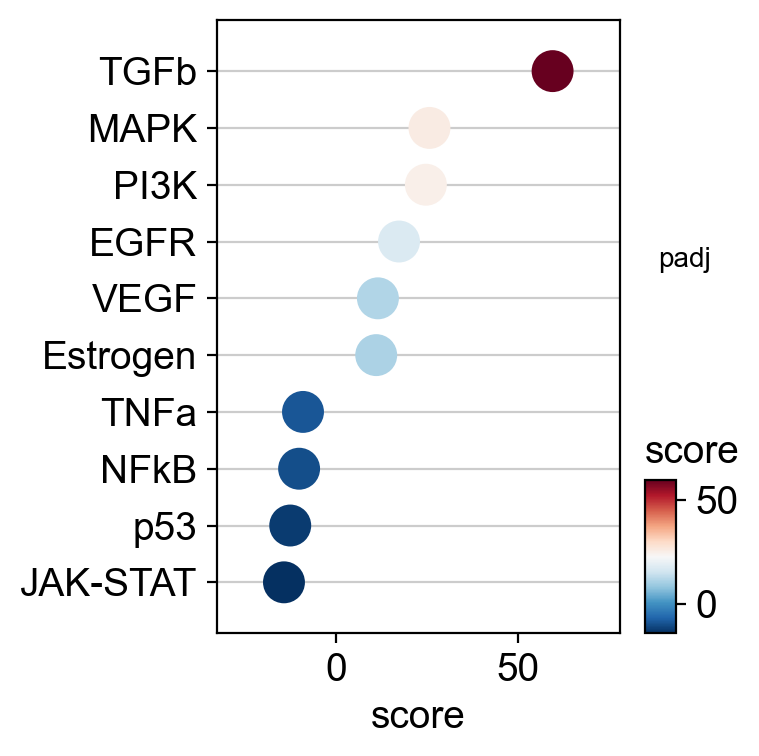

In [23]:
# Tranform to df
df = (
    pw_acts
    .melt(value_name='score')
    .merge(
        pw_padj
        .melt(value_name='padj')
        .assign(padj=lambda x: x['padj'].clip(2.22e-16, 1))
        .assign(padj=lambda x: np.log10(x['padj']))
    )
)
dc.pl.dotplot(
    df=df,
    x='score',
    y='variable',
    s='padj',
    c='score',
    scale=0.15,
    figsize=(4, 4)
)

As expected, treatment with the cytokine TGF-β results in increased activity of the TGF-β pathway.

Conversely, the treatment appears to reduce the activity of other pathways, such as JAK-STAT and p53.

The targets of the TGF-β pathway can be visualized in a scatter plot.

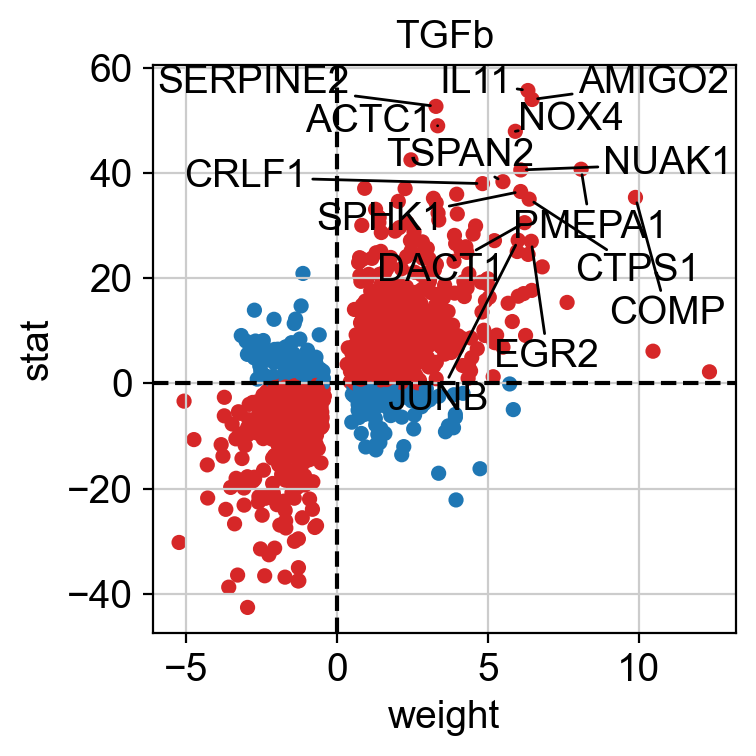

In [24]:
dc.pl.source_targets(
    data=results_df,
    x='weight',
    y='stat',
    net=progeny,
    name='TGFb',
    top=15,
    figsize=(4, 4)
)

The observed activation of the TGF-β pathway is driven by the fact that most of its positively weighted
target genes have positive t-values (first quadrant), while most of the negatively weighted targets have
negative t-values (third quadrant).

We can also visualize the targets of TGF-β as a leading edge plot.
Because PROGENy includes both positive and negative target genes,
the leading edge plot can be separated into positive and negative components.

(+) leading edge: ['IL11' 'AMIGO2' 'SERPINE2' 'ACTC1' 'NOX4']
(-) leading edge: ['SMAD3' 'ADAMTS1' 'GALNT15' 'HGF' 'NID2']


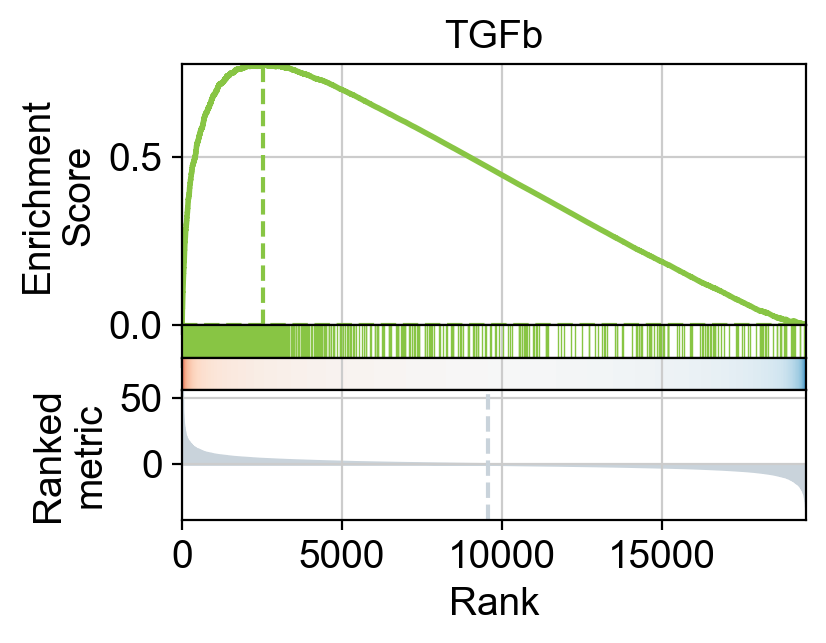

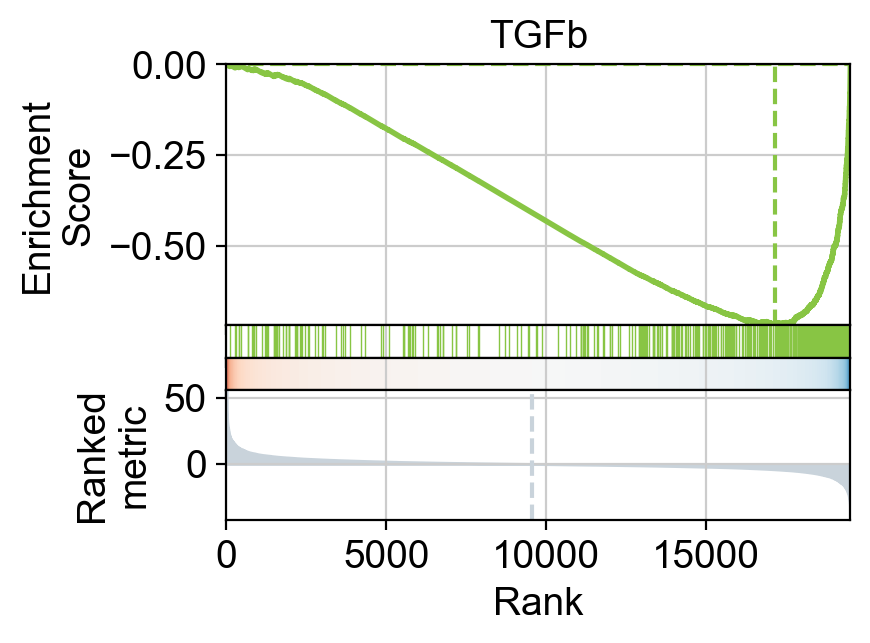

In [25]:
_, pos_le = dc.pl.leading_edge(
    results_df,
    stat='stat',
    net=progeny[progeny['weight'] > 0],
    name='TGFb',
)
print('(+) leading edge:', pos_le[:5])
_, neg_le = dc.pl.leading_edge(
    results_df,
    stat='stat',
    net=progeny[progeny['weight'] < 0],
    name='TGFb',
)
print('(-) leading edge:', neg_le[:5])

#### Hallmark gene sets
[Hallmark](https://www.gsea-msigdb.org/gsea/msigdb/human/collection_details.jsp#H)
gene sets are curated collections of genes that represent specific, well-defined biological states or processes.
They are part of MSigDB and were developed to reduce redundancy and improve interpretability compared to older,
more overlapping gene set collections {cite:p}`msigdb`.

A total of 50 gene sets are provided, designed to be non-redundant, concise, and biologically coherent.

This is how to access them.

In [26]:
hallmark = dc.op.hallmark(organism='human')
hallmark

,source,target
0,IL2_STAT5_SIGNALING,MAFF
1,COAGULATION,MAFF
2,HYPOXIA,MAFF
3,TNFA_SIGNALING_VIA_NFKB,MAFF
4,COMPLEMENT,MAFF
...,...,...
7313,PANCREAS_BETA_CELLS,STXBP1
7314,PANCREAS_BETA_CELLS,ELP4
7315,PANCREAS_BETA_CELLS,GCG
7316,PANCREAS_BETA_CELLS,PCSK2


#### Scoring
Pathway scores can be easily computed by running the `ulm` method.

In [27]:
# Run
hm_acts, hm_padj = dc.mt.ulm(data=data, net=hallmark)

# Filter by sign padj
msk = (hm_padj.T < 0.05).iloc[:, 0]
hm_acts = hm_acts.loc[:, msk]

hm_acts

,ADIPOGENESIS,ALLOGRAFT_REJECTION,APICAL_SURFACE,APOPTOSIS,BILE_ACID_METABOLISM,COMPLEMENT,E2F_TARGETS,EPITHELIAL_MESENCHYMAL_TRANSITION,FATTY_ACID_METABOLISM,G2M_CHECKPOINT,...,MYC_TARGETS_V1,MYC_TARGETS_V2,MYOGENESIS,P53_PATHWAY,PROTEIN_SECRETION,REACTIVE_OXYGEN_SPECIES_PATHWAY,TGF_BETA_SIGNALING,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,XENOBIOTIC_METABOLISM
treatment.vs.control,-2.246252,-3.418481,-2.707689,-3.981952,-2.344713,-4.22352,8.114239,13.570338,-2.431708,8.3056,...,5.278148,2.516328,6.550469,-3.530944,2.502391,-6.564499,5.379312,-3.502281,4.943592,-4.416553


The obtained scores for the most active and inactive pathways can be visualized as follows.

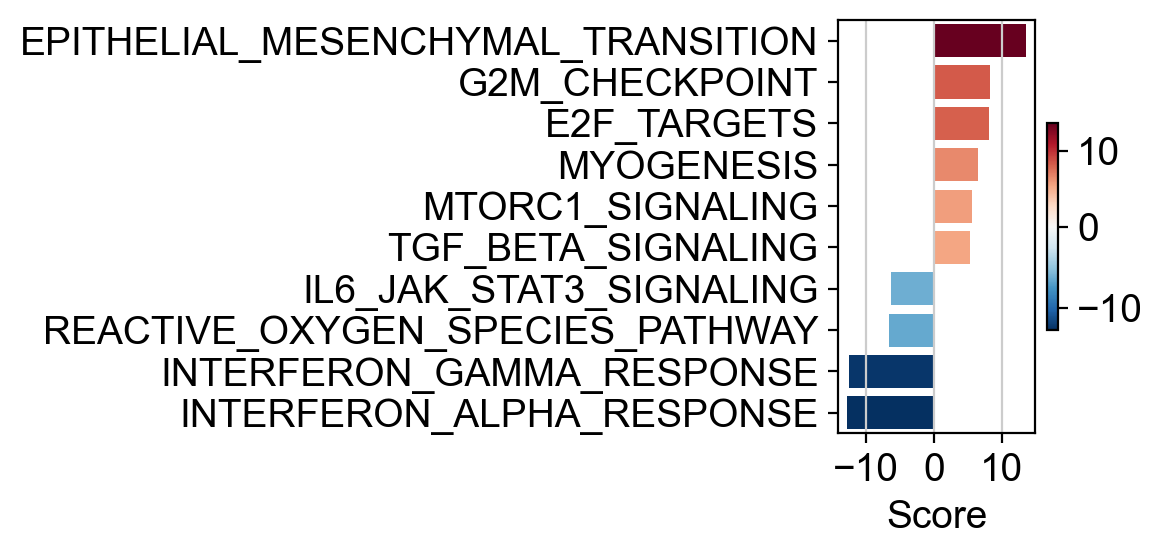

In [28]:
dc.pl.barplot(
    data=hm_acts,
    top=10,
    name='treatment.vs.control',
    figsize=(6, 3)
)

Or alternatively like this.

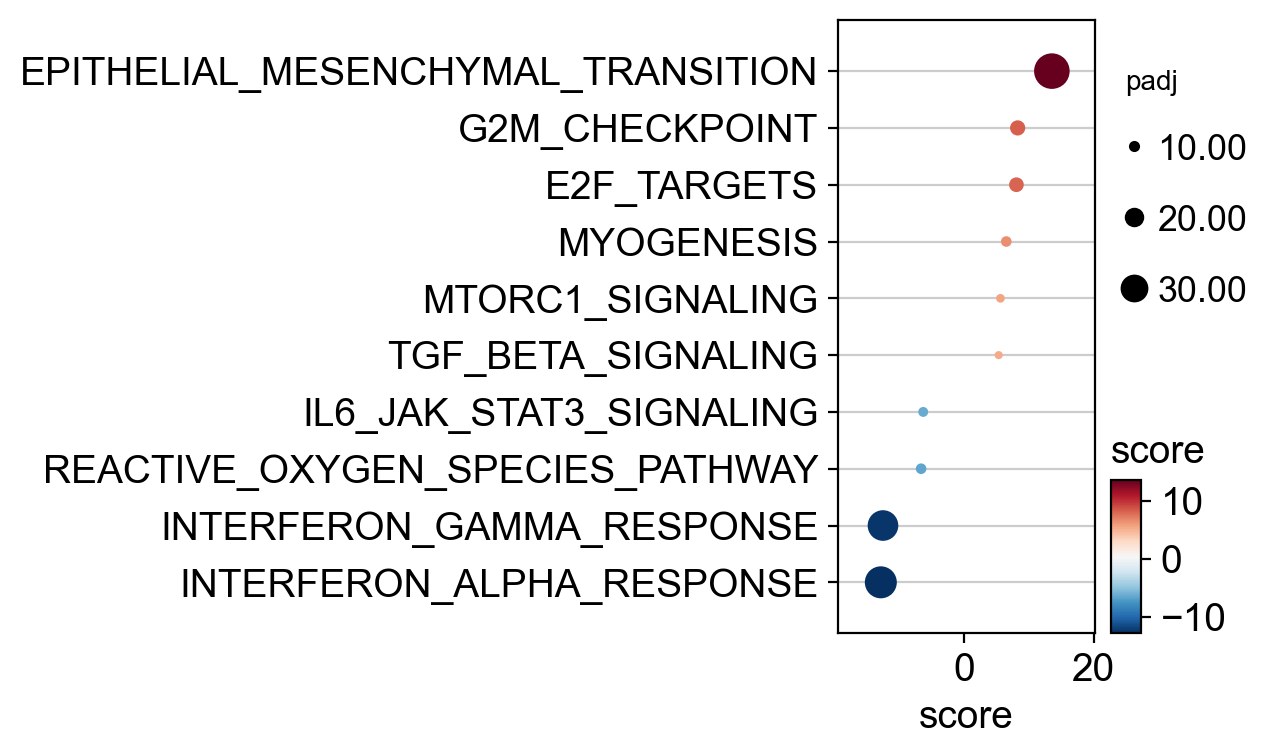

In [29]:
# Tranform to df
df = (
    hm_acts
    .melt(value_name='score')
    .merge(
        hm_padj
        .melt(value_name='pvalue')
        .assign(padj=lambda x: x['pvalue'].clip(2.22e-16, 1))
        .assign(padj=lambda x: np.log10(x['pvalue']))
    )
)
dc.pl.dotplot(
    df=df,
    x='score',
    y='variable',
    s='padj',
    c='score',
    top=10,
    scale=0.05,
    figsize=(6.5, 4)
)

Hallmark gene sets identify `TGF_BETA_SIGNALING` as a positively activated significant pathway but
not as significant as `EPITHELIAL_MESENCHYMAL_TRANSITION`.

Targets of the `TGF_BETA_SIGNALING` can be visualized as a leading
edge plot.

leading edge: ['PMEPA1' 'JUNB' 'SKIL' 'LTBP2' 'KLF10']


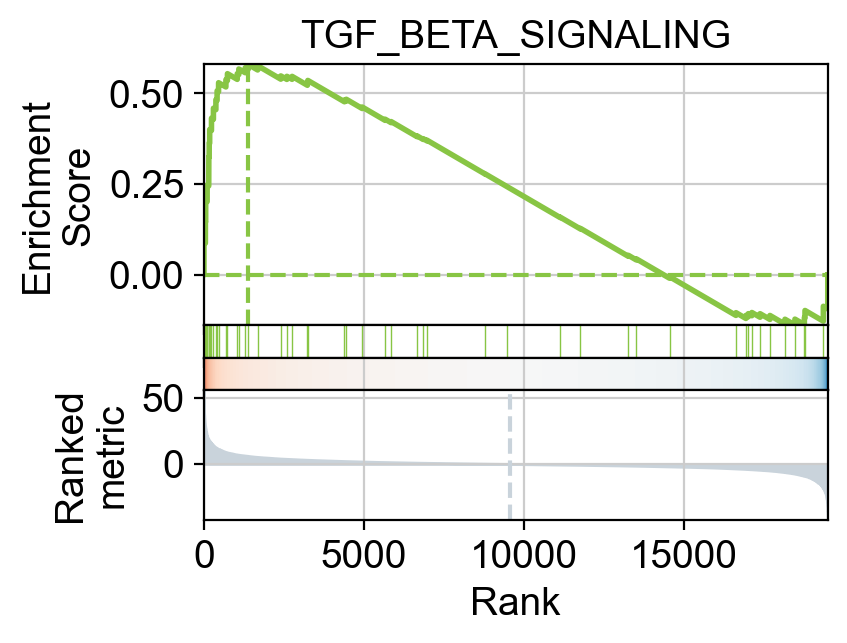

In [30]:
_, le = dc.pl.leading_edge(
    results_df,
    stat='stat',
    net=hallmark,
    name='TGF_BETA_SIGNALING',
)
print('leading edge:', le[:5])